# CH4 자세 추정

In [1]:
import os.path as osp
import random
# 파일이나 텍스트에서 XML을 읽고, 가공하고 저장하기 위한 라이브러리
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
import torch.nn as nn
import json
import time
import torch.nn.functional as F

%matplotlib inline

## Ch4.2 데이터셋과 데이터 로더 구현

### CH4.2.3 화상 데이터, 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트 작성

In [2]:
json_path = '/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/data/COCO.json'

data = json.load(open(json_path))
print(type(data))
print(data.keys())

<class 'dict'>
dict_keys(['root'])


In [3]:
def make_datapath_list(rootpath):
  """
  학습 및 검증 이미지 데이터와 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트 작성 함수
  """

  json_path = osp.join(rootpath, "COCO.json") # data folder에 COCO.json파일 존재함.
  with open(json_path) as data_file : 
    data_this = json.load(data_file) # dict type으로 반환된 데이터. 
    data_json = data_this['root'] # 데이터는 'root'의 키를 가지고 있음.

  # index 저장 - train_test split
  num_samples = len(data_json) # list형식의 데이터라서 len 메소드가 먹힘
  train_indexes = []
  val_indexes = []
  for count in range(num_samples):
    if data_json[count]['isValidation'] != 0.:
      val_indexes.append(count)
    else :
      train_indexes.append(count)

  # 화상 파일 경로 저장
  train_img_list = list()
  val_img_list = list()

  # 마스크 데이터 경로 저장
  train_mask_list = []
  val_mask_list = []

  # 어노테이션 데이터 저장
  train_meta_list = []
  val_meta_list = []

  for idx in train_indexes :
    img_path = osp.join(rootpath, data_json[idx]['img_paths'])
    train_img_list.append(img_path)

    img_idx = data_json[idx]['img_paths'][-16:-4] # 이미지 번호 (파일이름) 따오기
    anno_path= '/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/data/mask/train2014/mask_COCO_train2014_' + img_idx + '.jpg'
    train_mask_list.append(anno_path) # 절대경로를 리스트에 추가

    train_meta_list.append(data_json[idx]) # 정답데이터를 추가하자.

  for idx in val_indexes :
    img_path = osp.join(rootpath, data_json[idx]['img_paths'])
    val_img_list.append(img_path)

    img_idx = data_json[idx]['img_paths'][-16:-4] # 이미지 번호 (파일이름) 따오기
    anno_path= '/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/data/mask/val2014/mask_COCO_val2014_' + img_idx + '.jpg'
    val_mask_list.append(anno_path) # 절대경로를 리스트에 추가

    val_meta_list.append(data_json[idx])# 정답데이터를 추가하자.

  return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list



In [4]:
train_img_list, train_mask_list, val_img_list, val_mask_list,train_meta_list, val_meta_list = make_datapath_list('/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/data')
print(train_img_list[0])
print(train_mask_list[0])
print(val_img_list[0]) 
print(val_mask_list[0])
print(train_meta_list[0])
print(val_meta_list[0])

/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/data/train2014/COCO_train2014_000000000036.jpg
/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/data/mask/train2014/mask_COCO_train2014_000000000036.jpg
/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/data/val2014/COCO_val2014_000000000136.jpg
/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/data/mask/val2014/mask_COCO_val2014_000000000136.jpg
{'dataset': 'COCO', 'isValidation': 0.0, 'img_paths': 'train2014/COCO_train2014_000000000036.jpg', 'img_width': 481.0, 'img_height': 640.0, 'objpos': [322.885, 395.485], 'image_id': 36.0, 'bbox': [167.58, 162.89, 310.61, 465.19], 'segment_area': 86145.297, 'num_keypoints': 13.0, 'joint_self': [[250.0, 244.0, 1.0], [265.0, 223.0, 1.0], [235.0, 235.0, 1.0], [309.0, 227.0, 1.0], [235.0, 253.0, 1.0], [355.0, 337.0, 1.0], [215.0, 342.0, 1.0], [407.0, 494.0, 1.0], [213.0, 520.0, 1.0], 

### CH4.2.4 마스크 데이터 동작 확인

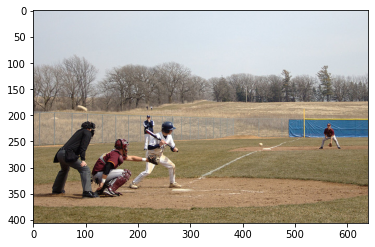

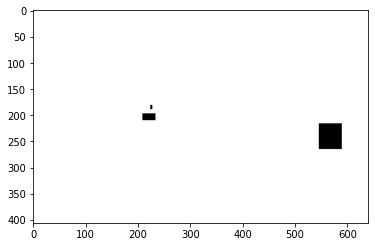

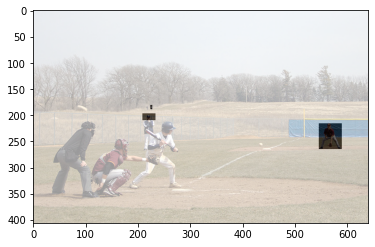

In [5]:
index = 24

img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

img2 = cv2.imread(val_mask_list[index])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

blended = cv2.addWeighted(img, 0.4, img2, 0.6, 0)
plt.imshow(blended)
plt.show()

### CH4.2.5 화상 전처리 구현

In [6]:
cd /content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation

/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation


In [7]:
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad
from utils.data_augumentation import aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
  """
  화상과 마스크, 어노테이션을 동시에 전처리해주는 클래스
  학습과 추론 시에는 서로 다르게 작동한다 
  """

  def __init__(self):

    self.data_transform = {
        'train' : Compose([
                           get_anno(), # JSON에 기록된 어노테이션을 딕셔너리에 저장한다.
                           add_neck(), # 어노테이션 데이터의 순서를 변경하며 목의 어노테이션을 추가한다.
                           aug_scale(), # 0.5 ~ 1.1 스케일링
                           aug_rotate(), # ghlwjs
                           aug_croppad(), # 자르기
                           aug_flip(), # 좌우반전
                           remove_illegal_joint(), # 이미지에서 없어진 어노테이션 제거
                           no_Normalize_Tensor() # 색상 정보의 표준화는 잠깐 생략한다.
        ]),
        'val' : Compose([
                         # 검증에서는 암것도 없다.
        ])
    }

  def __call__(self, phase, meta_data, img, mask_miss):
      """
      Parameters 
      -------------
      phase : 'train' or 'val' - 전처리 모드 지정
      meta_data : 어노테이션 데이터
      img : 이미지 데이터
      mask_miss : 마스크 데이터
      """

      meta_data, img, mask_miss = self.data_transform[phase](meta_data,img,mask_miss)
      return meta_data, img, mask_miss


In [8]:
# 데이터 처리 클래스와 데이터 확장 클래스를 import
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
    """
    화상과 마스크, 어노테이션의 전처리 클래스.
    학습시와 추론시에 서로 다르게 동작한다.
    학습시에는 데이터 확장을 수행한다.
    """

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                get_anno(),  # JSON에서 어노테이션을 사전에 저장
                add_neck(),  # 어노테이션 데이터의 순서를 변경하고, 목의 어노테이션 데이터를 추가
                aug_scale(),  # 확대 축소
                aug_rotate(),  # 회전
                aug_croppad(),  # 자르기
                aug_flip(),  # 좌우 반전
                remove_illegal_joint(),  # 화상에서 밀려나온 어노테이션을 제거
                # Normalize_Tensor()  # 색상 정보의 표준화 및 텐서화
                no_Normalize_Tensor()  # 여기서는 색상 정보의 표준화를 생략
            ]),
            'val': Compose([
                # 검증을 생략
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리의 모드를 지정.
        """
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)

        return meta_data, img, mask_miss

In [9]:
print(cv2.imread(val_img_list[index]).shape)
print(img.shape)

(406, 640, 3)
(406, 640, 3)


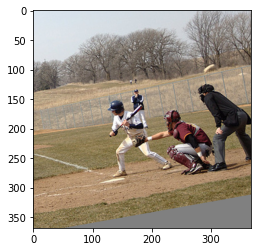

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


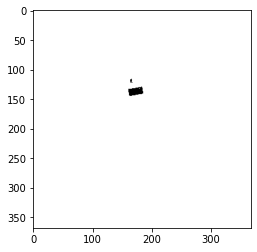

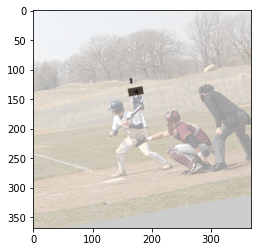

In [10]:
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]
transform = DataTransform() # 인스턴스 생성
meta_data, img, mask_miss = transform("train",meta_data, img, mask_miss) # 전처리 진행

img = img.numpy().transpose((1,2,0))
plt.imshow(img)
plt.show()

mask_miss = mask_miss.numpy().transpose((1,2,0))
plt.imshow(mask_miss)
plt.show()

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert("RGB"))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

###CH4.2.6 훈련데이터의 정답 정보로 사용할 어노테이션 데이터 작성

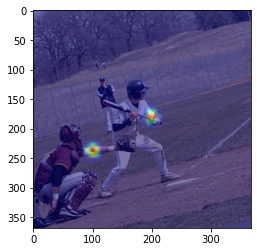

In [11]:
from utils.dataloader import get_ground_truth
from matplotlib import cm

index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]
transform = DataTransform() # 인스턴스 생성
meta_data, img, mask_miss = transform("train",meta_data, img, mask_miss) # 전처리 진행

img = img.numpy().transpose((1,2,0))
mask_miss = mask_miss.numpy().transpose((1,2,0))

heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

heat_map = heatmaps[:,:,6] # 6 - 왼쪽팔꿈치의 번호이다
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map.numpy())*255))
heat_map = np.asarray(heat_map.convert("RGB"))
heat_map = cv2.resize(heat_map, (img.shape[1],img.shape[0]), interpolation = cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [12]:
blend_img.shape

(368, 368, 3)

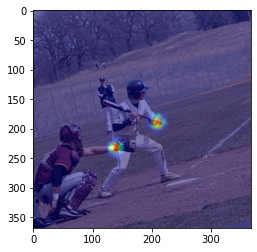

In [13]:
heat_map = heatmaps[:,:,7] # 7 - 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map.numpy())*255))
heat_map = np.asarray(heat_map.convert("RGB"))
heat_map = cv2.resize(heat_map, (img.shape[1],img.shape[0]), interpolation = cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

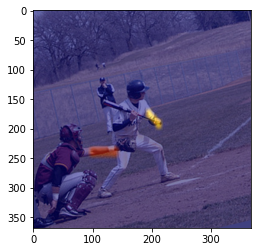

In [14]:
heat_map = pafs[:,:,24] # 24 - 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x벡터의 PAF
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map.numpy())*255))
heat_map = np.asarray(heat_map.convert("RGB"))
heat_map = cv2.resize(heat_map, (img.shape[1],img.shape[0]), interpolation = cv2.INTER_CUBIC)

blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

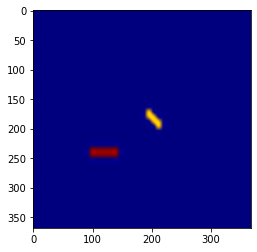

In [15]:
paf = pafs[:,:,24]
paf = Image.fromarray(np.uint8(cm.jet(paf.numpy())*255))
paf = np.asarray(paf.convert("RGB"))
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation = cv2.INTER_CUBIC)
plt.imshow(paf)
plt.show()

### CH4.2.7 데이터셋 작성

In [16]:
import torch.utils.data as data

class COCOkeypointsDataset(data.Dataset):
  """
  MSCOCO 키포인트 검출 데이터셋을 작성하는 클래스. data.Dataset 상속함

  Attributes
  -----------
  img_list : list - 이미지 파일의 경로를 저장한 리스트
  anno_list : list - 어노테이션 경로를 저장한 리스트
  phase : 'train' or 'val' 학습 상태를 설정하는 문자열
  transform : object - 전처리 클래스의 인스턴스
  """

  def __init__(self, img_list, mask_list, meta_list, phase, transform):
    self.img_list = img_list
    self.mask_list = mask_list
    self.meta_list = meta_list
    self.phase = phase
    self.transform = transform

  def __len__(self):
    """이미지 갯수 반환"""
    return len(self.img_list)

  def __getitem__(self, index):
    """호출될 때 자동으로 이친구에 의해 데이터가 읽혀짐"""
    img, heatmaps,heat_mask, pafs, paf_mask = self.pull_item(index)
    return img, heatmaps,heat_mask, pafs, paf_mask

  def pull_item(self,index): # getitem의 실구현
    img = cv2.imread(self.img_list[index]) # 리스트에서부터 이미지 읽기
    mask_miss = cv2.imread(self.mask_list[index]) # 리스트에서부터 마스크 읽기
    meta_data = self.meta_list[index] # 받아들인 메타데이터 인덱싱하기
    meta_data, img , mask_miss = self.transform(self.phase, meta_data, img , mask_miss) # 데이터 전처리 적용하기
    mask_miss_numpy = mask_miss.numpy().transpose((1,2,0)) # 형변환

    heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss_numpy) # 구현되어 있는 함수로 정답 구하기
    heat_mask = heat_mask[:,:,:,0] # 차원축소
    paf_mask = paf_mask[:,:,:,0] # 차원축소
    paf_mask = paf_mask.permute(2,0,1) # 차원 변경 - 채널, 너비, 높이 ( 원래는 너비 높이 채널)
    heat_mask = heat_mask.permute(2,0,1)
    pafs = pafs.permute(2,0,1)
    heatmaps = heatmaps.permute(2,0,1)

    return img, heatmaps, heat_mask, pafs, paf_mask

In [17]:
train_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase = 'train', transform = DataTransform())
val_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase = 'val', transform = DataTransform())

item = train_dataset.__getitem__(0)
print(item[0].shape) # img
print(item[1].shape) # heatmaps
print(item[2].shape) # heat_mask
print(item[3].shape) # pafs
print(item[4].shape) # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


###CH4.2.8 데이터 로더 작성

In [74]:
batch_size = 32

train_dataloader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}
batch_iterator = iter(dataloaders_dict["train"])
item = next(batch_iterator)

print(item[0].shape) # img
print(item[1].shape) # heatmaps
print(item[2].shape) # heat_mask
print(item[3].shape) # pafs
print(item[4].shape) # paf_mask

torch.Size([32, 3, 368, 368])
torch.Size([32, 19, 46, 46])
torch.Size([32, 19, 46, 46])
torch.Size([32, 38, 46, 46])
torch.Size([32, 38, 46, 46])


## CH4.3 오픈포즈 네트워크 구성 및 구현

### CH4.3.2 OpenPoseNet 구현

In [19]:
class OpenPoseNet(nn.Module):
  def __init__(self):
    super(OpenPoseNet, self).__init__() # 상속

    #Feature
    self.model0 = OpenPose_Feature() # VGG-16 특징추출 네트워크

    #각 Stage 모듈들
    # PAFs
    self.model1_1 = make_OpenPose_block('block1_1')
    self.model2_1 = make_OpenPose_block('block2_1')
    self.model3_1 = make_OpenPose_block('block3_1')
    self.model4_1 = make_OpenPose_block('block4_1')
    self.model5_1 = make_OpenPose_block('block5_1')
    self.model6_1 = make_OpenPose_block('block6_1')
    #Confidence Heatmap
    self.model1_2 = make_OpenPose_block('block1_2')
    self.model2_2 = make_OpenPose_block('block2_2')
    self.model3_2 = make_OpenPose_block('block3_2')
    self.model4_2 = make_OpenPose_block('block4_2')
    self.model5_2 = make_OpenPose_block('block5_2')
    self.model6_2 = make_OpenPose_block('block6_2')
    print("Model 세팅 완료")

  def forward(self,x):
    #Feature추출
    out1 = self.model0(x) # 각 스테이지의 입력으로 사용 됨.

    #Stage1
    out1_1 = self.model1_1(out1) # 1 - 점과 점 사이의 클래스 예측 (38종)
    out1_2 = self.model1_2(out1) # 2 - 점의 히트맵 예측 (19점)

    #Stage2
    out2 = torch.cat([out1, out1_1, out1_2],1) # 채널 축 axis = 1 으로 합치기
    out2_1 = self.model2_1(out2)
    out2_2 = self.model2_2(out2)

    #Stage3
    out3 = torch.cat([out1, out2_1, out2_2],1) # 채널 축 axis = 1 으로 합치기
    out3_1 = self.model3_1(out3)
    out3_2 = self.model3_2(out3)

    #Stage4
    out4 = torch.cat([out1, out3_1, out3_2],1) # 채널 축 axis = 1 으로 합치기
    out4_1 = self.model4_1(out4)
    out4_2 = self.model4_2(out4)

    #Stage5
    out5 = torch.cat([out1, out4_1, out4_2],1) # 채널 축 axis = 1 으로 합치기
    out5_1 = self.model5_1(out5)
    out5_2 = self.model5_2(out5)

    #Stage6
    out6 = torch.cat([out1, out5_1, out5_2],1) # 채널 축 axis = 1 으로 합치기
    out6_1 = self.model6_1(out6)
    out6_2 = self.model6_2(out6) 


    #손실 계산을 위하여 각 스테이지의 결과를 저장해 둔다.
    save_for_loss = []
    save_for_loss.append(out1_1)
    save_for_loss.append(out2_1)
    save_for_loss.append(out3_1)
    save_for_loss.append(out4_1)
    save_for_loss.append(out5_1)
    save_for_loss.append(out6_1)
    save_for_loss.append(out1_2)
    save_for_loss.append(out2_2)
    save_for_loss.append(out3_2)
    save_for_loss.append(out4_2)
    save_for_loss.append(out5_2)
    save_for_loss.append(out6_2)

    return (out6_1, out6_2) ,save_for_loss


##CH4.4 Feature 및 Stage 모듈 설명 및 구현

###CH4.4.1 모듈의 구성 및 구현

In [20]:
# VGG16을 베이스라인으로 삼는다.
import torchvision

class OpenPose_Feature(nn.Module):
  def __init__(self):
    super(OpenPose_Feature, self).__init__()

    vgg16 = torchvision.models.vgg16(pretrained = True)
    model ={}
    model['block0'] = vgg16.features[0:23] # 최초 10개의 합성곱 층을 가져온다.
    model['block0'].add_module("23", torch.nn.Conv2d(512,256,kernel_size=3,stride = 1, padding = 1))
    model['block0'].add_module("24", torch.nn.ReLU(inplace = True))
    model['block0'].add_module("25", torch.nn.Conv2d(256,128,kernel_size=3,stride = 1, padding = 1))
    model['block0'].add_module("26", torch.nn.ReLU(inplace = True))
    self.model = model["block0"] # 왜 여기서? 딕셔너리로?

  def forward(self,x):
    return self.model(x)

###CH4.4.2 각 Stage 모듈의 블록 구성 및 구현

In [21]:
import torch.nn.init as init

def make_OpenPose_block(block_name):
  """
  구성 변수에서 오픈포즈 Stage 모듈의 블록 작성 
  nn.Sequential 로 짜여진다.
  """

  #구성의 사전형 변수 block을 작성하여 네트워크를 생성시킨다.
  #다 준비는 해 두고, 받은 인수에 따라 선별적으로 생성한다.

  blocks = {}
  blocks['block1_1'] = [{'conv5_1_CPM_L1':[128,128,3,1,1]},
                        {'conv5_1_CPM_L1':[128,128,3,1,1]},
                        {'conv5_1_CPM_L1':[128,128,3,1,1]},
                        {'conv5_1_CPM_L1':[128,512,1,1,0]}, # FCN을 사용한다.
                        {'conv5_1_CPM_L1':[512,38,1,1,0]}]

  blocks['block1_2'] = [{'conv5_1_CPM_L2':[128,128,3,1,1]},
                        {'conv5_1_CPM_L2':[128,128,3,1,1]},
                        {'conv5_1_CPM_L2':[128,128,3,1,1]},
                        {'conv5_1_CPM_L2':[128,512,1,1,0]}, # FCN을 사용한다.
                        {'conv5_1_CPM_L2':[512,19,1,1,0]}]

  for i in range(2,7):
    blocks['block%d_1' % i] = [
                               {'Mconv1_stage%d_L1'%i:[185,128,7,1,3]},
                               {'Mconv2_stage%d_L1'%i:[128,128,7,1,3]},
                               {'Mconv3_stage%d_L1'%i:[128,128,7,1,3]},
                               {'Mconv4_stage%d_L1'%i:[128,128,7,1,3]},
                               {'Mconv5_stage%d_L1'%i:[128,128,7,1,3]},
                               {'Mconv6_stage%d_L1'%i:[128,128,1,1,0]},
                               {'Mconv7_stage%d_L1'%i:[128,38,1,1,0]},
    ]
    blocks['block%d_2' % i] = [
                               {'Mconv1_stage%d_L2'%i:[185,128,7,1,3]},
                               {'Mconv2_stage%d_L2'%i:[128,128,7,1,3]},
                               {'Mconv3_stage%d_L2'%i:[128,128,7,1,3]},
                               {'Mconv4_stage%d_L2'%i:[128,128,7,1,3]},
                               {'Mconv5_stage%d_L2'%i:[128,128,7,1,3]},
                               {'Mconv6_stage%d_L2'%i:[128,128,1,1,0]},
                               {'Mconv7_stage%d_L2'%i:[128,19,1,1,0]},
    ]

  cfg_dict = blocks[block_name] # 딕서녀리에서 설정을 호출
  layers = []

  for i in range(len(cfg_dict)):
    for k,v in cfg_dict[i].items(): # key와 value
      if 'pool' in k :
        layers += [nn.MaxPool2d(kernel_size = v[0], out_channels = v[1], padding = v[2])] # 여기에는 풀링 코드가 없어
      else :
        conv2d = nn.Conv2d(in_channels = v[0], out_channels=v[1], kernel_size = v[2], stride = v[3], padding = v[4] )
        layers = layers + [conv2d, nn.ReLU(inplace = True)]

  net = nn.Sequential(*layers[:-1]) # 레이어의 모든 층을 시퀸셜에 전달하여 네트워크를 구축한다. 마지막 Relu는 빼고 넣는다.

  # 가중치 초기화 함수로 합성곱 층 초기화
  def _initialize_weights_norm(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d): #입력한 녀석이 합성곱 인스턴스인가?
        init.normal_(m.weight, std = 0.01)
        if m.bias is not None:
          init.constant_(m.bias, 0.)

  net.apply(_initialize_weights_norm)
  return net


In [87]:
net = OpenPoseNet()
net.train()

batch_size = 2
dummy_img = torch.rand(batch_size, 3,368,368)
outputs = net(dummy_img)
print("PAFs output : ",outputs[0][0].shape)
print("Joint point output : ",outputs[0][1].shape)
print(outputs[1])

PAFs output :  torch.Size([2, 38, 46, 46])
Joint point output :  torch.Size([2, 19, 46, 46])
[tensor([[[[-3.8014e-05, -6.1797e-05, -8.5342e-05,  ..., -6.5079e-05,
           -8.1897e-05, -1.7571e-05],
          [ 2.7809e-06, -6.2277e-06, -4.7102e-05,  ..., -1.9626e-05,
           -5.4613e-06, -2.8845e-05],
          [-3.0932e-05, -3.8843e-05, -6.7192e-05,  ..., -5.3856e-05,
           -5.3504e-05, -5.9948e-05],
          ...,
          [-5.3496e-06, -5.2676e-05, -3.5918e-05,  ..., -6.7726e-05,
           -5.3914e-05, -4.1881e-05],
          [ 6.0133e-06, -2.8090e-05, -1.0740e-05,  ..., -2.7339e-05,
           -1.2440e-05, -1.9805e-05],
          [ 5.0135e-06,  1.8271e-05, -2.6028e-05,  ..., -4.3830e-06,
           -3.4675e-05, -1.5536e-05]],

         [[-1.3274e-05,  1.2801e-05,  4.4865e-05,  ...,  5.8092e-05,
            4.6423e-05,  2.7519e-05],
          [ 4.4406e-05,  1.2049e-04,  7.7296e-05,  ...,  1.0175e-04,
            5.7428e-05,  3.9350e-05],
          [ 4.9845e-05,  9.9210e-

##CH4.5 텐서보드 시각화

/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:965: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  argument_names,


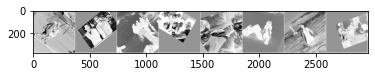

In [24]:
from utils.openpose_net import OpenPoseNet

net = OpenPoseNet()
net.train()

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/OpenPose')

dataiter = iter(train_dataloader)
images = dataiter.next()[0]

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다
writer.add_image('batched images', img_grid)
writer.add_graph(net, images)
writer.close()

In [31]:
%reload_ext tensorboard
%tensorboard --logdir {"./runs/OpenPose"}

Reusing TensorBoard on port 6006 (pid 2527), started 0:59:19 ago. (Use '!kill 2527' to kill it.)

<IPython.core.display.Javascript object>

## CH4.6 오픈포즈 학습

###CH4.6.3 손실함수 정의

In [79]:
class OpenPoseLoss(nn.Module):
  """오픈포즈의 손실함수 클래스 """
  def __init__(self):
    super(OpenPoseLoss, self).__init__()

  def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask):
    """
    Parameters
    ----------
    saved_for_loss : OpenPoseNet 출력 (리스트 형태)
    heatmap_target : [batch_size, 19, 46, 46] - 정답 부위의 어노테이션 정보
    heatmap_mask : [batch_size, 38, 46, 46] - 히트맵 화상의 마스크
    paf_target : [batch_size, 38, 46, 46] - 정답 부위의 PAF 어노테이션 정보
    paf_mask : [batch_size, 38, 46, 46] - PAF의 마스크

    Returns 
    --------------
    loss : 텐서 손실 값

    """

    total_loss = 0

    for j in range(6):
      pred1 = saved_for_loss[2*j]*paf_mask # paf_mask를 곱함으로써 작은 사람은 무시하게 됨.
      gt1 = paf_target.float() * paf_mask

      pred2 = saved_for_loss[2*j+1]*heat_mask # heat_mask를 곱함으로써 작은 사람은 무시하게 됨.
      gt2 = heatmap_target.float() * heat_mask

      total_loss += F.mse_loss(pred1, gt1, reduction='mean') + \
                F.mse_loss(pred2, gt2, reduction='mean')
    return total_loss

criterion = OpenPoseLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2,
                      momentum=0.9,
                      weight_decay=0.0001)

### CH4.6.4 학습 실시

In [80]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("current device : ",device)
  net.to(device)
  torch.backends.cudnn.benchmark = True
  num_train_imgs = len(dataloaders_dict["train"].dataset)
  batch_size = dataloaders_dict["train"].batch_size
  print("batch size : ", batch_size)
  iteration = 1 # 반복횟수 카운트

  for epoch in range(num_epochs):
    t_epoch_start = time.time()
    t_iter_start = time.time()
    epoch_train_loss = 0.
    epoch_val_loss = 0.
    print('---------------------------------')
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    print('---------------------------------')

    for phase in ['train', 'val']:
      if phase == 'train' :
        net.train()
        optimizer.zero_grad()
        print("Trainig...")
      else : 
        continue # 검증은 생략. 훈련 과정일 때만 보자

      for imges, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase]:
        if imges.size()[0] == 1:
          continue # 배치정규화 에러를 피하기 위함.

        imges = imges.to(device)
        heatmap_target = heatmap_target.to(device)
        heat_mask = heat_mask.to(device)
        paf_target = paf_target.to(device)
        paf_mask = paf_mask.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          _, saved_for_loss = net(imges)
          loss = criterion(saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask)
          del saved_for_loss
          if phase == 'train':
            loss.backward()
            optimizer.step()

            if (iteration % 10 == 0):
              t_iter_finish = time.time()
              duration = t_iter_finish - t_iter_start
              print("반복 {} || LOSS : {:.4f} || 10iter : {:.4f}sec".format(iteration, loss.item()/batch_size, duration))
              t_iter_start = time.time()
            epoch_train_loss += loss.item()
            iteration += 1

            # 검증은 생략함.
    
    t_epoch_finish = time.time()
    print('---------------------------------')
    print("EPOCH {} || Epoch_Train_LOSS : {:.4f} || Epoch_val_LOSS : {:.4f}".format(epoch+1, epoch_train_loss/num_train_imgs,0))
    print("timer : {:.4f}sec.".format(t_epoch_finish - t_epoch_start))
    t_epoch_start = time.time()
  torch.save(net.state_dict(), 'weights/openpose_net_'+str(epoch+1)+".pth") # 저장


In [81]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

current device :  cuda:0
batch size :  32
---------------------------------
Epoch 1/2
---------------------------------
Trainig...
반복 10 || LOSS : 0.0093 || 10iter : 43.9439sec
반복 20 || LOSS : 0.0080 || 10iter : 44.3598sec
반복 30 || LOSS : 0.0069 || 10iter : 42.5071sec
반복 40 || LOSS : 0.0058 || 10iter : 43.7926sec
반복 50 || LOSS : 0.0051 || 10iter : 43.5983sec
반복 60 || LOSS : 0.0043 || 10iter : 42.2212sec
반복 70 || LOSS : 0.0036 || 10iter : 41.9938sec
반복 80 || LOSS : 0.0031 || 10iter : 41.8515sec
반복 90 || LOSS : 0.0029 || 10iter : 43.0264sec
반복 100 || LOSS : 0.0025 || 10iter : 45.8623sec
반복 110 || LOSS : 0.0022 || 10iter : 42.5298sec
반복 120 || LOSS : 0.0021 || 10iter : 42.3986sec
반복 130 || LOSS : 0.0018 || 10iter : 41.3753sec
반복 140 || LOSS : 0.0017 || 10iter : 43.7808sec
반복 150 || LOSS : 0.0019 || 10iter : 44.6314sec
---------------------------------
EPOCH 1 || Epoch_Train_LOSS : 0.0043 || Epoch_val_LOSS : 0.0000
timer : 667.6991sec.
---------------------------------
Epoch 2/2
----------

##CH4.7 오픈포즈 추론

In [92]:
from utils.openpose_net import OpenPoseNet

# 학습된 모델과 이 장의 모델은 네트워크 계층의 이름이 다르므로 대응시켜 로드한다
# 모델 정의
net = OpenPoseNet()

# 학습된 파라미터를 읽는다
net_weights = torch.load(
    '/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/4_pose_estimation/weights/openpose_net_2.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# 로드한 내용을 이 책에서 구축한 모델의
# 파라미터명 net.state_dict().keys()로 복사
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

# 복사한 내용을 모델에 할당
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')

네트워크 설정 완료: 학습된 가중치를 로드했습니다


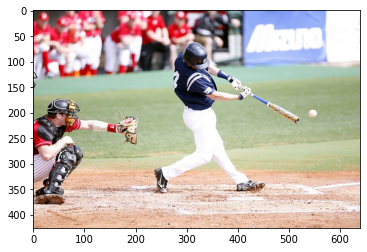

In [93]:
# 야구 화상을 읽어, 전처리합니다
test_image = './data/hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  # B,G,R의 순서

# BGR을 RGB로 하여 표시
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 화상 리사이즈
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 화상 전처리
img = img.astype(np.float32) / 255.

# 색상 정보의 표준화
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# (높이, 폭, 색) → (색, 높이, 폭)
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 화상을 Tensor로
img = torch.from_numpy(img)

# 미니 배치화: torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

In [103]:
net(x)[0][1].max()

tensor(0.9122, grad_fn=<MaxBackward1>)

In [109]:
net(x)[0][1].detach().numpy().shape

(1, 19, 46, 46)

In [110]:
# OpenPose로 heatmaps과 PAFs를 구합니다
net.eval()
predicted_outputs, _ = net(x)

# 화상을 텐서에서 NumPy로 변환해, 크기를 반환합니다
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

In [114]:
# 학습은 잘 안 된 듯

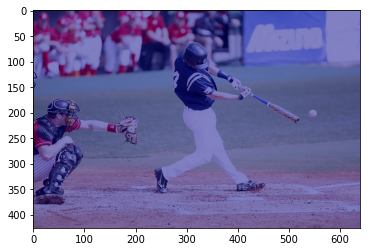

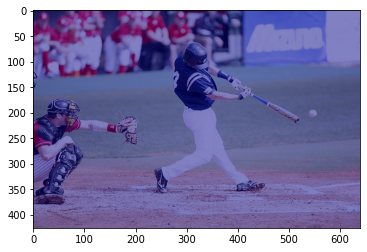

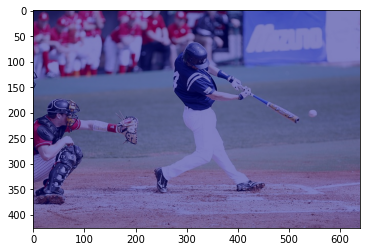

In [105]:
# 왼쪽 팔꿈치와 왼쪽 손목의 heatmap, 그리고 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터를 시각화한다
# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# 합성해서 표시
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [97]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

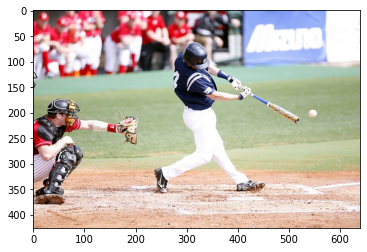

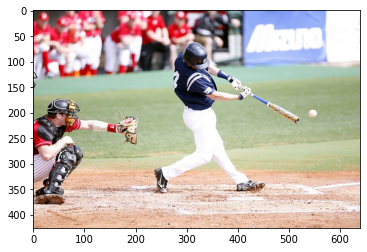

In [98]:
# 결과를 화면에 그리기
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()